In [2]:
import numpy as np
import scipy.io
import pickle
import cv2
import matplotlib.pyplot as plt
import os,math
from tqdm import tqdm
from src.lrw import generate_seeds,energy_opt
from src.utils import im2double,seg2bmap
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, random_walker
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [3]:
Thres=1.35 #threshold for split
beta=30 #gaussian parameter 
alpha=0.9992 #Lazy parameter
nItrs_max = 10 #limit for the number of iterations

dataset_path = "gt/images/val/"
benchmark_path = "gt/ground_truth/val/"

ue_arr_ours = []
asa_arr_ours = []

ue_arr_slic = []
asa_arr_slic = []

ue_quickshift = []
asa_quickshift = []

ue_watershed = []
asa_watershed = []

ue_rw = []
asa_rw = []

In [4]:
def is4ConnectedBoundaryPixel(labels, i, j):
    if i > 0 and labels[i][j] != labels[i-1][j]:
        return True
    if i < labels.shape[0] - 1 and labels[i][j] != labels[i+1][j]:
        return True
    if j > 0 and labels[i][j] != labels[i][j-1]:
        return True
    if j < labels.shape[1] - 1 and labels[i][j] != labels[i][j+1]:
        return True
    return False

In [5]:
def computeIntersectionMatrix(labels, gt):
    superpixels = np.max(labels)
    gt_segments = np.max(gt)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i][j] > superpixels:
                superpixels = labels[i][j]
            if gt[i][j] > gt_segments:
                gt_segments = gt[i][j]
    superpixels+=1;
    gt_segments+=1;
#     superpixel_sizes.resize(superpixels, 0);
#     gt_sizes.resize(gt_segments, 0);
    
    intersection_matrix = np.zeros([gt_segments, superpixels])
#     // Rember to reset as not done in create.
    superpixel_sizes = np.zeros([superpixels])
    gt_sizes = np.zeros([gt_segments])
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            intersection_matrix[gt[i][j]][labels[i][j]] += 1
            superpixel_sizes[labels[i][j]] += 1
            gt_sizes[gt[i][j]] += 1

    return intersection_matrix, superpixel_sizes, gt_sizes

In [6]:
def boundaryRecall(gt, pred, d):
    assert gt.shape[0] == pred.shape[0] and gt.shape[1] == pred.shape[1]
    h = gt.shape[0]
    w = gt.shape[1]
    r = np.round(d*(h*h+w*w)**(1/2))
    tp = 0
    fn = 0
    for i in range(h):
        for j in range(w):
            if is4ConnectedBoundaryPixel(gt, i, j):
                pos = False
                for k in range(max(0, i-r), min(h - 1, i + r) + 1):
                    for l in range(max(0, j - r), min(w - 1, j + r) + 1):
                        if is4ConnectedBoundaryPixel(pred, k, l):
                            pos = True
                if pos:
                    tp += 1
                else:
                    fn += 1
    if tp + fn > 0:
        return tp/(tp + fn)
    
    return 0

In [7]:
def computeAchievableSegmentationAccuracy(gt, pred):
    assert gt.shape[0] == pred.shape[0] and gt.shape[1] == pred.shape[1]
    h = gt.shape[0]
    w = gt.shape[1]
    n = h*w
    intersection_matrix, superpixel_sizes, gt_sizes = computeIntersectionMatrix(pred, gt)
    acc = 0
    for j in range(intersection_matrix.shape[1]):
        mx = 0
        for i in range(intersection_matrix.shape[0]):
            if intersection_matrix[i][j] > mx:
                mx = intersection_matrix[i][j]
        acc += mx
    return acc

In [8]:
def computeUndersegmentationError(gt, pred):
    assert gt.shape[0] == pred.shape[0] and gt.shape[1] == pred.shape[1]
    h = gt.shape[0]
    w = gt.shape[1]
    n = h*w
    intersection_matrix, superpixel_sizes, gt_sizes = computeIntersectionMatrix(pred, gt)
    error = 0
    for j in range(intersection_matrix.shape[1]):
        mn = float('inf')
        for i in range(intersection_matrix.shape[0]):
            tmp = superpixel_sizes[j] - intersection_matrix[i][j]
            if tmp  < mn:
                mn = tmp
        error += mn
    return error/n

In [8]:
for filename in (os.listdir(dataset_path)):
    try:
        path = os.path.join(dataset_path,filename)
        img = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
        scale_percent = 25
        width = math.ceil(img.shape[1] * scale_percent / 100)
        height = math.ceil(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        mat_ext = filename[:-4]+".mat"
        #     print (mat_ext)
        bench_path = os.path.join(benchmark_path,mat_ext)
        mat = scipy.io.loadmat(bench_path)
        gt = mat['groundTruth'][0][0][0][0][0]
        Nsp = int(np.max(gt))
        if (Nsp>=300 or Nsp<10):
            Nsp = 20
        gt = cv2.resize(gt, dim, interpolation = cv2.INTER_AREA)

        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        gray_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
        orig_img = img.copy()
        img = im2double(img)
        X,Y,Z = img.shape
        print (filename, img.shape, gt.shape, Nsp)
        seeds = generate_seeds(Nsp,im2double(gray_img/255))
        pred, _, _ = energy_opt(orig_img, seeds, alpha, Nsp, nItrs_max, beta, Thres)
        marker, _, _ = energy_opt(orig_img, seeds, alpha, Nsp, nItrs_max, beta, 1)

        segments_slic = slic(img, n_segments=Nsp, compactness=10, sigma=1,
                             start_label=1)
        segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
        gradient = sobel(rgb2gray(img))
        segments_watershed = watershed(gradient, markers=250, compactness=0.001)
        segments_rw = random_walker(gray_img, marker, beta=30)

        ue1 = computeUndersegmentationError(gt, pred)
        asa1 = computeAchievableSegmentationAccuracy(gt, pred)
        ue_arr_ours.append(ue1)
        asa_arr_ours.append(asa1)
        ue2 = computeUndersegmentationError(gt, segments_slic)
        asa2 = computeAchievableSegmentationAccuracy(gt, segments_slic)
        ue_arr_slic.append(ue2)
        asa_arr_slic.append(asa2)
        ue3 = computeUndersegmentationError(gt, segments_quick)
        asa3 = computeAchievableSegmentationAccuracy(gt, segments_quick)
        ue_quickshift.append(ue3)
        asa_quickshift.append(asa3)
        ue4 = computeUndersegmentationError(gt, segments_watershed)
        asa4 = computeAchievableSegmentationAccuracy(gt, segments_watershed)
        ue_watershed.append(ue4)
        asa_watershed.append(asa4)
        ue5 = computeUndersegmentationError(gt, segments_rw)
        asa5 = computeAchievableSegmentationAccuracy(gt, segments_rw)
        ue_rw.append(ue5)
        asa_rw.append(asa5)
    except:
        print ("Img/mat not found")

33039.jpg (121, 81, 3) (121, 81) 12
86016.jpg (81, 121, 3) (81, 121) 24
130026.jpg (81, 121, 3) (81, 121) 20
156065.jpg (81, 121, 3) (81, 121) 20
123074.jpg (81, 121, 3) (81, 121) 12
271035.jpg (121, 81, 3) (121, 81) 32
260058.jpg (81, 121, 3) (81, 121) 19
78004.jpg (121, 81, 3) (121, 81) 25
106024.jpg (81, 121, 3) (81, 121) 18
220075.jpg (81, 121, 3) (81, 121) 27
108070.jpg (81, 121, 3) (81, 121) 20
167062.jpg (81, 121, 3) (81, 121) 20
304074.jpg (121, 81, 3) (121, 81) 14
196073.jpg (81, 121, 3) (81, 121) 20
65033.jpg (81, 121, 3) (81, 121) 40
45096.jpg (81, 121, 3) (81, 121) 20
89072.jpg (121, 81, 3) (121, 81) 13
62096.jpg (81, 121, 3) (81, 121) 17
197017.jpg (81, 121, 3) (81, 121) 16
299086.jpg (81, 121, 3) (81, 121) 44
210088.jpg (121, 81, 3) (121, 81) 20
19021.jpg (81, 121, 3) (81, 121) 15
108082.jpg (81, 121, 3) (81, 121) 20
170057.jpg (81, 121, 3) (81, 121) 30
175032.jpg (121, 81, 3) (121, 81) 23
296007.jpg (81, 121, 3) (81, 121) 23
97033.jpg (81, 121, 3) (81, 121) 13
37073.jpg 

<ipython-input-8-d9834c8b4406>:34: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  segments_rw = random_walker(gray_img, marker, beta=30)


241004.jpg (81, 121, 3) (81, 121) 17
295087.jpg (81, 121, 3) (81, 121) 20
223061.jpg (81, 121, 3) (81, 121) 12
69040.jpg (81, 121, 3) (81, 121) 40
306005.jpg (81, 121, 3) (81, 121) 20
16077.jpg (81, 121, 3) (81, 121) 25
241048.jpg (81, 121, 3) (81, 121) 20
148089.jpg (81, 121, 3) (81, 121) 13
8023.jpg (81, 121, 3) (81, 121) 20
42012.jpg (121, 81, 3) (121, 81) 14
145086.jpg (81, 121, 3) (81, 121) 21
157055.jpg (81, 121, 3) (81, 121) 33
160068.jpg (81, 121, 3) (81, 121) 10
101087.jpg (121, 81, 3) (121, 81) 29
385039.jpg (81, 121, 3) (81, 121) 14
43074.jpg (81, 121, 3) (81, 121) 20
76053.jpg (81, 121, 3) (81, 121) 20
134035.jpg (81, 121, 3) (81, 121) 20
126007.jpg (81, 121, 3) (81, 121) 21
189080.jpg (121, 81, 3) (121, 81) 20
285079.jpg (121, 81, 3) (121, 81) 38
216081.jpg (81, 121, 3) (81, 121) 66
143090.jpg (81, 121, 3) (81, 121) 20
147091.jpg (81, 121, 3) (81, 121) 16
167083.jpg (121, 81, 3) (121, 81) 20
300091.jpg (81, 121, 3) (81, 121) 20
304034.jpg (81, 121, 3) (81, 121) 20
109053.j

In [11]:
ue_arr_ours = np.array(ue_arr_ours)
asa_arr_ours = np.array(asa_arr_ours)

ue_arr_slic = np.array(ue_arr_slic)
asa_arr_slic = np.array(asa_arr_slic)

ue_quickshift = np.array(ue_quickshift)
asa_quickshift = np.array(asa_quickshift)

ue_watershed = np.array(ue_watershed)
asa_watershed = np.array(asa_watershed)

print ("UE LRW:",np.mean(ue_arr_ours))
print ("ASA LRW:",np.mean(asa_arr_ours))
print ("UE SLIC:",np.mean(ue_arr_slic))
print ("ASA SLIC:",np.mean(asa_arr_slic))
print ("UE RW:",np.mean(ue_rw))
print ("ASA RW:",np.mean(asa_rw))
print ("UE QUICKSHIFT:",np.mean(ue_quickshift))
print ("ASA QUICKSHIFT:",np.mean(asa_quickshift))
print ("UE WATERSHED:",np.mean(ue_watershed))
print ("ASA WATERSHED:",np.mean(asa_watershed))

UE LRW: 0.1603050709111315
ASA LRW: 8229.85
UE SLIC: 0.1885113763901643
ASA SLIC: 7953.4
UE RW: 0.17496377920620343
ASA RW: 8086.18
UE QUICKSHIFT: 0.09904703601673301
ASA QUICKSHIFT: 8830.24
UE WATERSHED: 0.08966738087950211
ASA WATERSHED: 8922.17


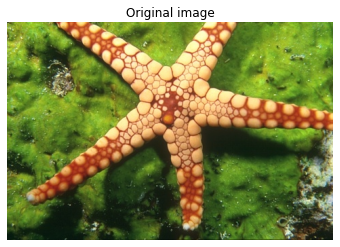

In [42]:
dummy_img = cv2.cvtColor(cv2.imread("gt/images/train/12003.jpg"),cv2.COLOR_BGR2RGB)
plt.imshow(dummy_img)
plt.axis("off")
plt.title("Original image")
plt.show()

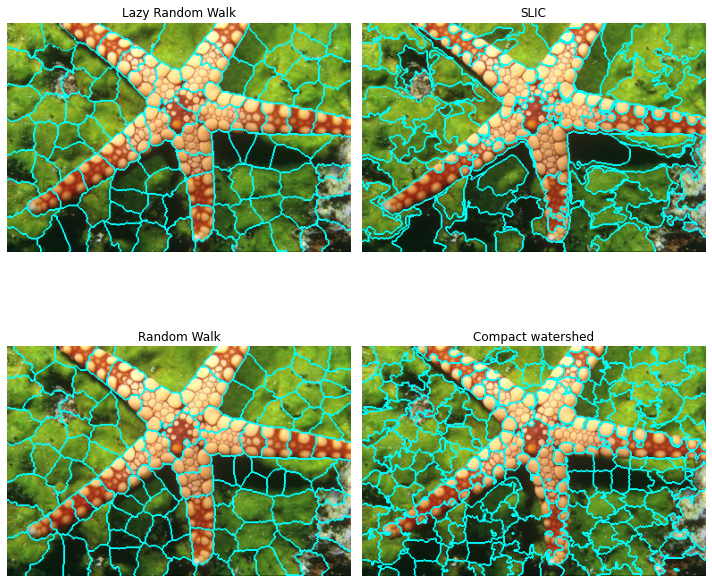

In [43]:
Nsp = 100

scale_percent = 80
width = math.ceil(dummy_img.shape[1] * scale_percent / 100)
height = math.ceil(dummy_img.shape[0] * scale_percent / 100)
dim = (width, height)

dummy_img = cv2.resize(dummy_img, dim, interpolation = cv2.INTER_AREA)
gray_dummy = cv2.cvtColor(dummy_img,cv2.COLOR_RGB2GRAY)
seeds = generate_seeds(Nsp,im2double(gray_dummy/255))
pred, _, _ = energy_opt(dummy_img, seeds, alpha, Nsp, nItrs_max, beta, Thres)
segments_slic = slic(dummy_img, n_segments=Nsp, compactness=10, sigma=1,
                             start_label=1)
segments_quick = quickshift(dummy_img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(dummy_img))
marker_dummy, _, _ = energy_opt(dummy_img, seeds, alpha, Nsp, nItrs_max, beta, 1)
segments_watershed = watershed(gradient, markers=250, compactness=0.001)
segments_rw = random_walker(gray_dummy, marker_dummy, beta=30)


fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(dummy_img, pred,color=(0,1,1)))
ax[0, 0].set_title("Lazy Random Walk")
ax[0, 1].imshow(mark_boundaries(dummy_img, segments_slic,color=(0,1,1)))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(dummy_img, segments_rw,color=(0,1,1)))
ax[1, 0].set_title('Random Walk')
ax[1, 1].imshow(mark_boundaries(dummy_img, segments_watershed,color=(0,1,1)))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

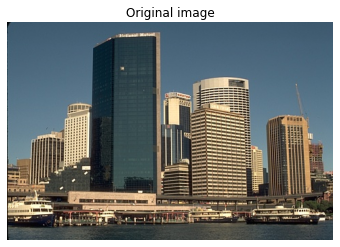

In [9]:
dummy_img = cv2.cvtColor(cv2.imread("gt/images/test/69007.jpg"),cv2.COLOR_BGR2RGB)
plt.imshow(dummy_img)
plt.axis("off")
plt.title("Original image")
plt.show()

 70%|███████   | 7/10 [00:44<00:18,  6.31s/it]


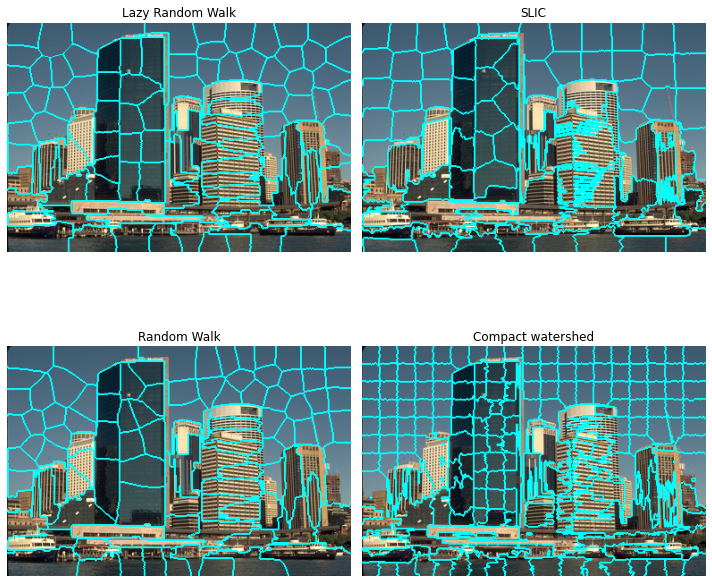

In [10]:
Nsp = 100

scale_percent = 80
width = math.ceil(dummy_img.shape[1] * scale_percent / 100)
height = math.ceil(dummy_img.shape[0] * scale_percent / 100)
dim = (width, height)

dummy_img = cv2.resize(dummy_img, dim, interpolation = cv2.INTER_AREA)
gray_dummy = cv2.cvtColor(dummy_img,cv2.COLOR_RGB2GRAY)
seeds = generate_seeds(Nsp,im2double(gray_dummy/255))
pred, _, _ = energy_opt(dummy_img, seeds, alpha, Nsp, nItrs_max, beta, Thres)
segments_slic = slic(dummy_img, n_segments=Nsp, compactness=10, sigma=1,
                             start_label=1)
segments_quick = quickshift(dummy_img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(dummy_img))
marker_dummy, _, _ = energy_opt(dummy_img, seeds, alpha, Nsp, nItrs_max, beta, 1)
segments_watershed = watershed(gradient, markers=250, compactness=0.001)
segments_rw = random_walker(gray_dummy, marker_dummy, beta=30)


fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(dummy_img, pred,color=(0,1,1)))
ax[0, 0].set_title("Lazy Random Walk")
ax[0, 1].imshow(mark_boundaries(dummy_img, segments_slic,color=(0,1,1)))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(dummy_img, segments_rw,color=(0,1,1)))
ax[1, 0].set_title('Random Walk')
ax[1, 1].imshow(mark_boundaries(dummy_img, segments_watershed,color=(0,1,1)))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()